In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as matplot
import seaborn as sns
import operator
import collections
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
%matplotlib inline
matplot.style.use('seaborn-whitegrid')
matplot.rcParams["figure.figsize"] = (15,15)

#read the csv file
df = pd.read_csv('Ames_Housing_data.csv')

In [2]:
#View the missing data
df.isnull().sum()[df.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [3]:
#Fill the NA value of LotFrontage with the mean value of the whole column
for i in range(0, len(df['LotFrontage'])):
    df['LotFrontage'].fillna(df['LotFrontage'].mean() , inplace = True)

#Fill the GarageYrBlt NA value with the mean value of the whole column
for i in range(0, len(df['GarageYrBlt'])):
    df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean() , inplace = True)

#Fill NaN with String 'NA'
df = df.fillna('NA')

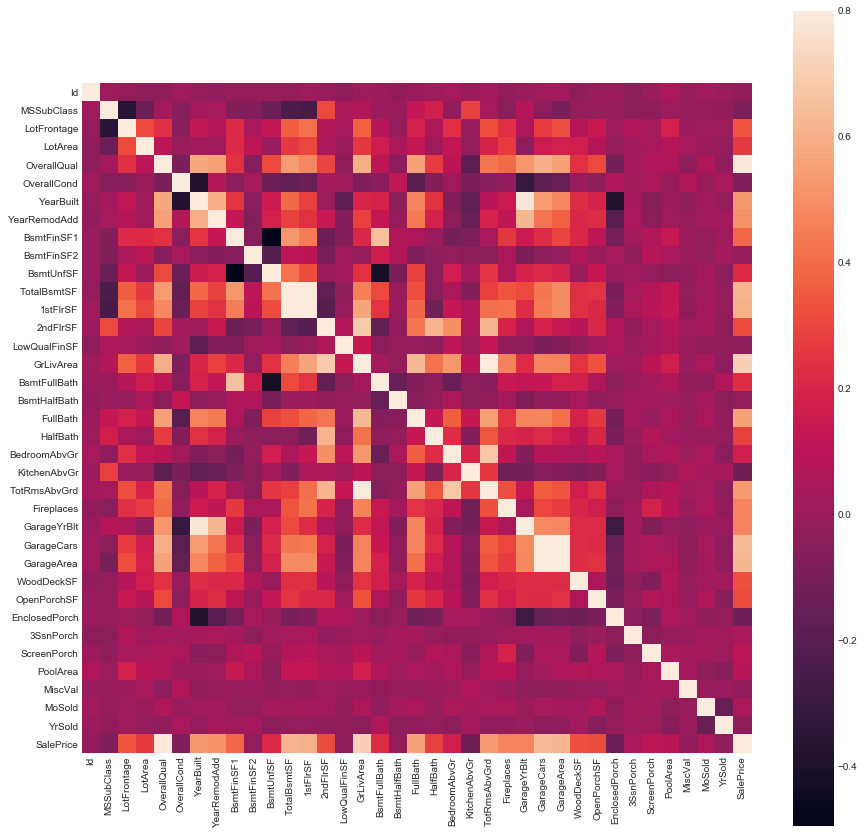

In [4]:
#Correlation heatmap
sns.heatmap(df.corr(), vmax=.8, square=True)

In [5]:
#Drop these categories since they seem to have no influence on the SalePrice or they have too much NA value
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
  'GarageType', 'GarageFinish','BsmtExposure', 'BsmtFinType2', 'BsmtFinType1',
 'MasVnrArea', 'MasVnrType', 'PoolArea'], axis = 1, inplace = True)

#We drop the row that has electrical as NA
df.drop(df[df.Electrical.isna()].index, axis = 0, inplace = True)

#For these variable, we concatenate into a new column, remove them and keep the concatenated column
df = df.assign(TotalFullBath = df['BsmtFullBath'] + df['FullBath'])
df.drop(['BsmtFullBath', 'FullBath'],axis = 1, inplace = True)
df = df.assign(TotalHalfBath = df['BsmtHalfBath'] + df['HalfBath'])
df.drop(['BsmtHalfBath', 'HalfBath'],axis = 1, inplace = True)
df.drop(['3SsnPorch', 'ScreenPorch', 'EnclosedPorch'],axis = 1, inplace = True)

In [6]:
#The list of all the numeric features in the data
numeric_features = df.dtypes[df.dtypes != "object"].index

In [7]:
#See the summary of SalePrice column
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
#The function to encoding some of the categorical variable that has the scale based on SalePrice
def encoding(column):
    list = set(df[column])
    dict = {key: 0 for key in list}
    for i in dict:
        sum = 0
        count = 0
        for k in range (len(df[column])):
            if(df[column][k] == i):
                sum = sum + df['SalePrice'][k]
                count = count + 1
        dict[i] = sum / count

    dict = collections.OrderedDict(sorted(dict.items(), key=lambda x: x[1]))

    count = 1
    for i in dict:
        dict[i] = count
        count = count + 1
    return dict

#These categorical variables have the scale based on SalePrice. We will identify the categories that have the highest SalePrice
#and give that categories the highest value, then do the same for the rest of other categories.
df['HouseStyle'] = df['HouseStyle'].map(encoding('HouseStyle'))
df['Neighborhood'] = df['Neighborhood'].map(encoding('Neighborhood'))
df['MSZoning'] = df['MSZoning'].map(encoding('MSZoning'))

In [9]:
#The encoding map
mp = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}

#These categorical variable have the categories map above
for feat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
 'HeatingQC', 'KitchenQual','GarageQual', 'GarageCond']:
     df[feat] = df[feat].map(mp)

#The encoding map
mp = {'N':0, 'Y':2 , 'P':1}

#These categorical variable have the categories map above
for feat in ['CentralAir', 'PavedDrive']:
    df[feat] = df[feat].map(mp)

#The encoding map
mp = {'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1}

#These categorical variable have the categories map above
df['Functional'] = df['Functional'].map(mp)

#The encoding map
mp = {'Gtl':1 ,'Mod':2 , 'Sev':3}

#These categorical variable have the categories map above
df['LandSlope'] = df['LandSlope'].map(mp)

#We fill the NaN in these column with NA
NA = [ 'GarageQual', 'GarageCond', 'BsmtCond', 'BsmtQual']
for na in NA:
    df[na].fillna('NA', inplace = True)

In [10]:
#Remove outliers
outlier_features = ['LotFrontage', 'LotArea','SalePrice', 'GarageArea']
for i in outlier_features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df.drop(df[(df[i] > Q3 + IQR * 1.5) | (df[i] < Q1 - IQR * 1.5)].index, inplace = True)
df.drop(df[df["GrLivArea"] > 4000].index, inplace=True)

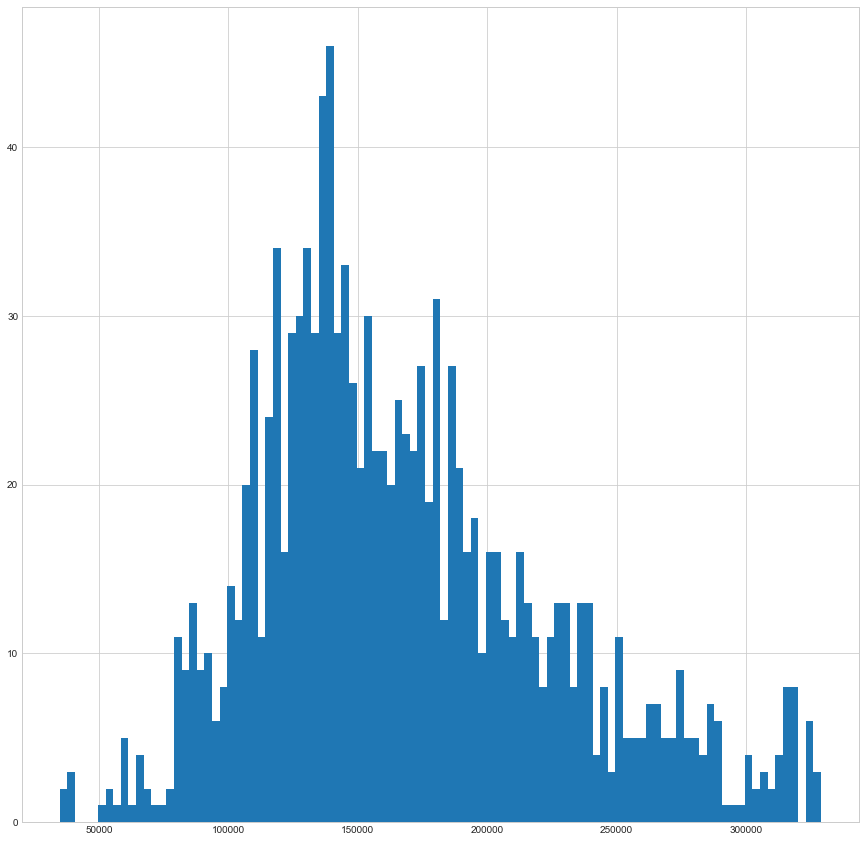

In [11]:
#Histogram for the SalePrice distribution
matplot.hist(df['SalePrice'], label = 'SalePrice', bins = 100)
matplot.show()

Text(0.5, 0, 'Ground Living Area')

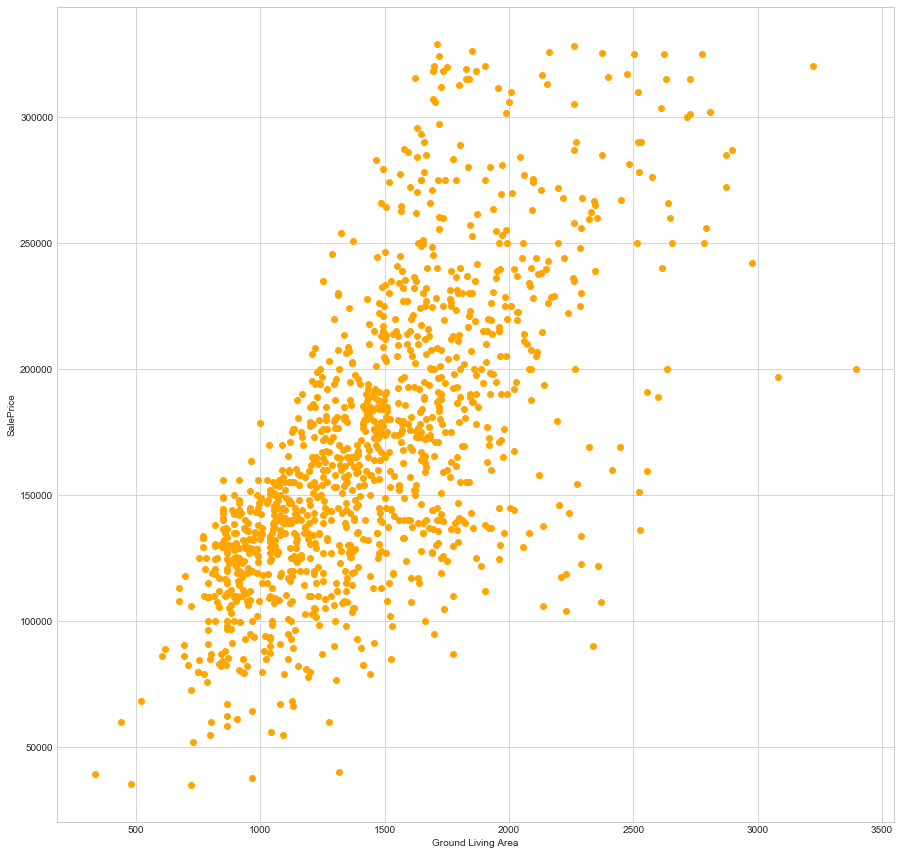

In [12]:
#Scatterplot for GroundLivingArea versus SalePrice
matplot.plot(df['GrLivArea'],df['SalePrice'],'o', color = 'orange')
matplot.ylabel('SalePrice')
matplot.xlabel('Ground Living Area')

Text(0.5, 0, 'Total square feet of basement area')

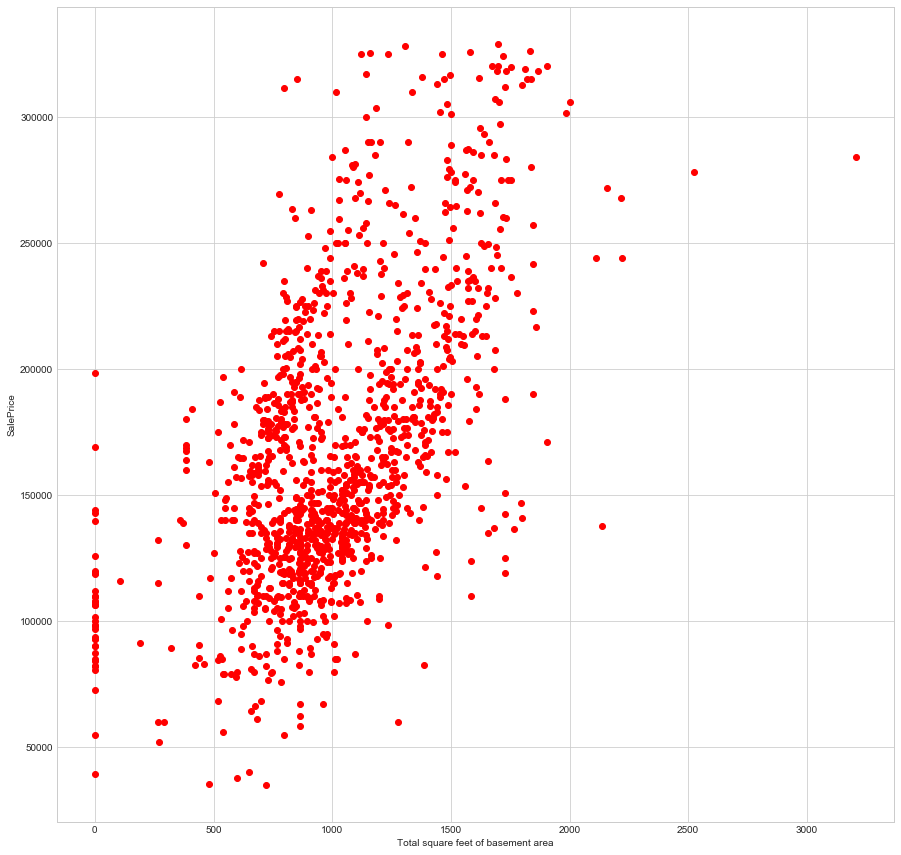

In [13]:
#Scatterplot for total square feet of basement area versus SalePrice
matplot.plot(df['TotalBsmtSF'], df["SalePrice"], 'o', color = 'red')
matplot.ylabel('SalePrice')
matplot.xlabel('Total square feet of basement area')

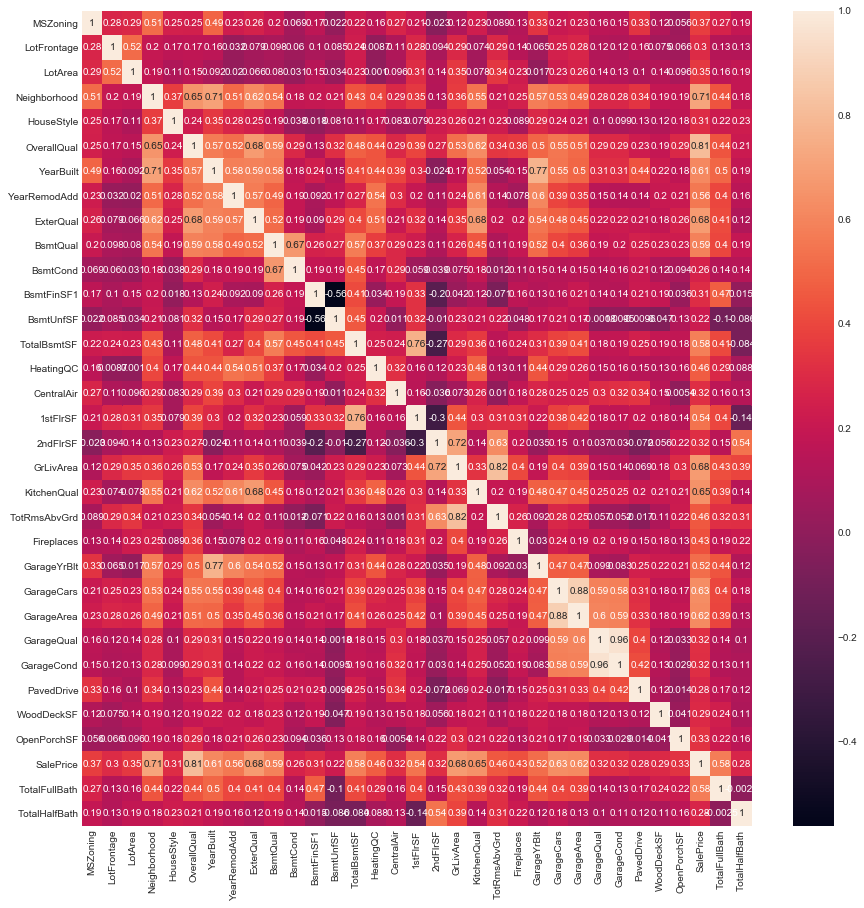

In [14]:
#Remove column with correlated values lower than 0.2
corr = df.corr()
rel_vars = corr.SalePrice[(corr.SalePrice > 0.2)]
rel_cols = list(rel_vars.index.values)

#Correlation HeatMap after removing column with correlated values lower than 0.2
corr2 = df[rel_cols].corr()
sns.heatmap(corr2, annot=True, annot_kws={'size':10})

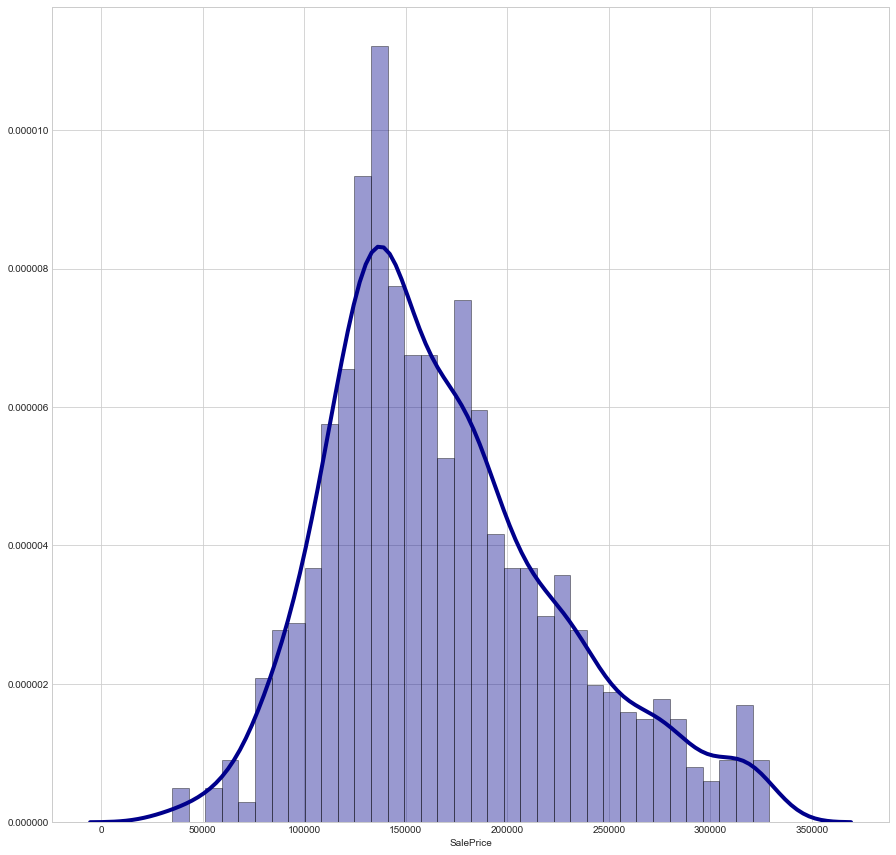

In [15]:
#SalePrice distribution with a curve goes over
sns.distplot(df['SalePrice'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.set_style("whitegrid")

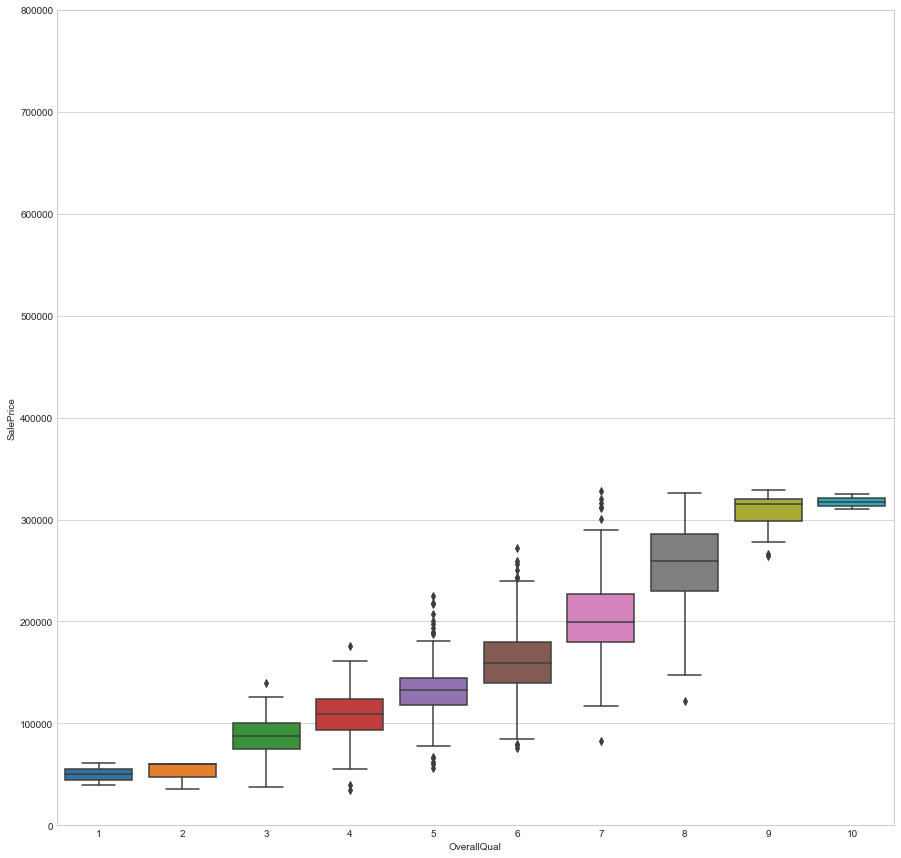

In [16]:
#Overall Quality visualization
var = 'OverallQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = matplot.subplots()
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


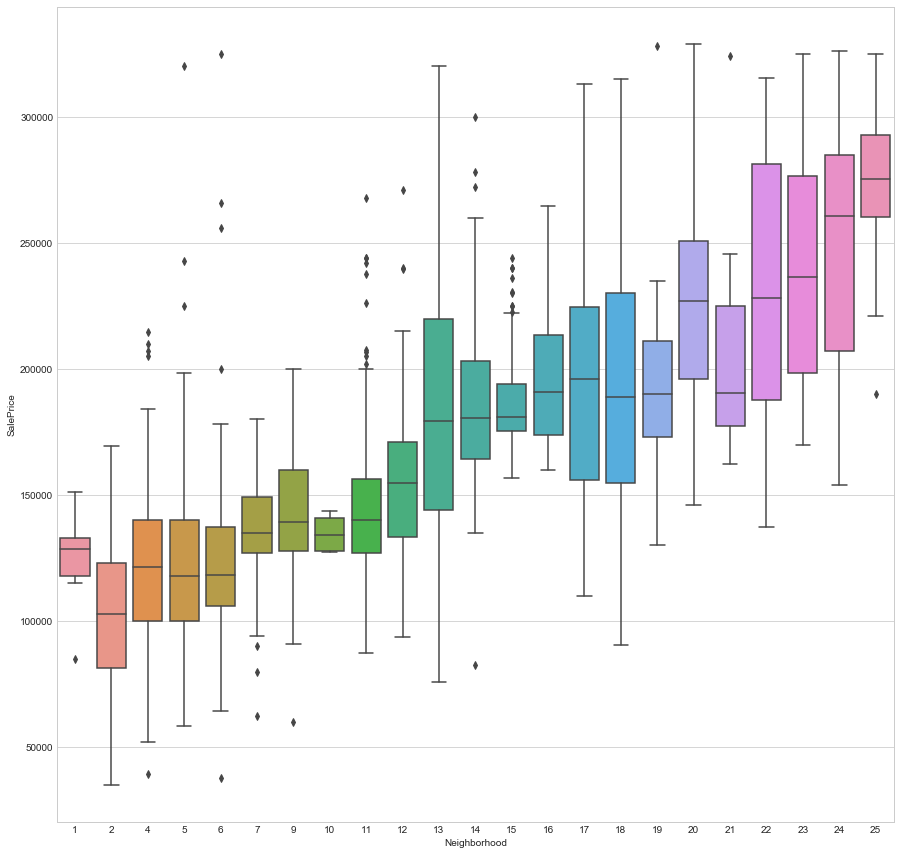

In [17]:
#Neighborhood versus SalePrice visualization
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = df)

In [18]:
from scipy.stats import skew

#Logarithm transformation for skew data column
skewed = df[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
df[skewed] = np.log1p(df[skewed])
df = pd.get_dummies(df)

In [19]:
#Train_test split
X = df.drop('SalePrice', axis = 1)
Y = df['SalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= 40)

In [20]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
import xgboost as xgboost
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import lightgbm as lgb

#Function to show the model result, including bar graphs
def result(model):
    Y_pred = model.predict(X_train)
    result = pd.DataFrame({'Actual': (Y_train), 'Predicted': (Y_pred)})
    
    print('THe accuracy of training set si is ', model.score(X_train, Y_train))
    print('THe accuracy of testing set si is ', model.score(X_test, Y_test))
    
    df1 = result.head(30)
    print(df1)
    df1.plot(kind='bar',figsize=(10,8))
    
    kfold = KFold(n_splits = 10, random_state=7, shuffle = True)
    results = np.sqrt(-cross_val_score(model, X_test, Y_test, cv=kfold, scoring = 'neg_mean_squared_error'))
    
    print("The root mean squared error is " + str(results.mean()) + " " + "(" + str(results.std()) + ")")

THe accuracy of training set si is  0.8796806105633481
THe accuracy of testing set si is  0.8905256532855628
      Actual      Predicted
1195  176000  179197.008715
248   180000  205520.007261
820   183000  199050.028332
1008  240000  223501.696579
1369  232000  224612.558892
167   325624  275735.124870
1299  154000  162863.378434
536   188000  200794.207361
827   189000  203291.639779
450   110000  124376.269886
865   148500  146183.430285
1096  127000  124688.986407
748   260400  239684.710788
1223  137900  168805.904202
129   150000  156631.896002
1394  246578  220347.136061
1041  173000  168971.573789
944   137500  147454.982349
1308  147000  148135.362895
1210  189000  204789.997907
1074  194000  199651.388228
155    79000   85931.432245
516   158000  171624.835236
292   131000  138977.238691
584   133000  120377.616342
1431  143750  140523.550172
913   145000  153751.872421
2     223500  220103.474769
860   189950  169725.798800
1255  127500  125348.449251
The root mean squared e

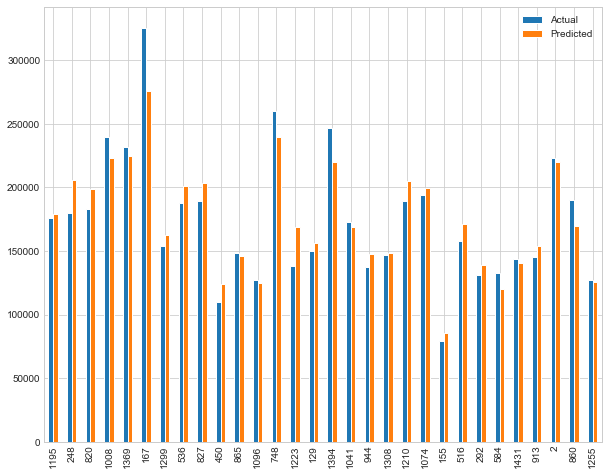

In [21]:
#Ridge model
ridge = Ridge(alpha = 1, normalize = True)
Ridge_pipeline = make_pipeline(ridge)
Ridge_pipeline.fit(X_train, Y_train)
result(Ridge_pipeline)

THe accuracy of training set si is  0.9999999983740075
THe accuracy of testing set si is  0.9263523107688323
      Actual      Predicted
1195  176000  175994.546875
248   180000  180005.062500
820   183000  183004.109375
1008  240000  239997.359375
1369  232000  232001.906250
167   325624  325624.843750
1299  154000  154000.859375
536   188000  187999.359375
827   189000  189000.109375
450   110000  109999.554688
865   148500  148502.375000
1096  127000  126999.218750
748   260400  260397.875000
1223  137900  137898.203125
129   150000  150001.937500
1394  246578  246579.000000
1041  173000  173001.093750
944   137500  137499.921875
1308  147000  147000.093750
1210  189000  189000.921875
1074  194000  193999.187500
155    79000   79000.578125
516   158000  158001.062500
292   131000  131000.867188
584   133000  132994.468750
1431  143750  143749.359375
913   145000  144999.734375
2     223500  223499.562500
860   189950  189948.000000
1255  127500  127497.382812
The root mean squared e

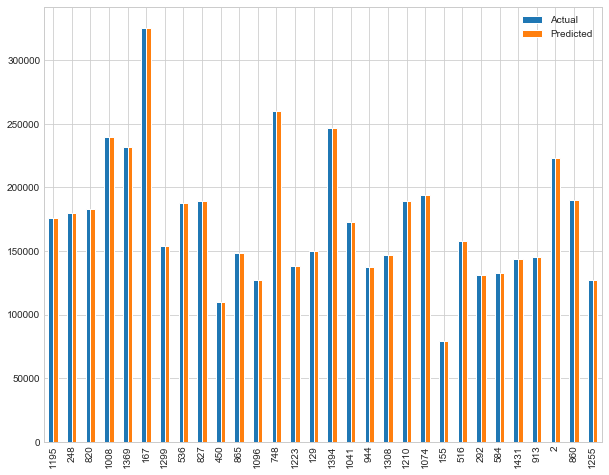

In [22]:
#XGBoost model
xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
XGB_pipeline = make_pipeline(xgb)
XGB_pipeline.fit(X_train, Y_train)
result(XGB_pipeline)

THe accuracy of training set si is  0.9030121378865386
THe accuracy of testing set si is  0.8831597999841714
      Actual      Predicted
1195  176000  168742.211905
248   180000  208956.918492
820   183000  197309.821796
1008  240000  225827.580766
1369  232000  232771.521012
167   325624  309505.924664
1299  154000  156005.442647
536   188000  198291.172933
827   189000  200911.648212
450   110000  135461.786009
865   148500  149718.011905
1096  127000  127247.749907
748   260400  251669.613553
1223  137900  172297.964693
129   150000  138687.580599
1394  246578  220173.936576
1041  173000  183634.090803
944   137500  137473.689869
1308  147000  145891.990098
1210  189000  207259.357010
1074  194000  205226.965916
155    79000  105274.123184
516   158000  180268.279553
292   131000  139376.881606
584   133000  132590.009358
1431  143750  128577.065379
913   145000  157470.157219
2     223500  225961.070066
860   189950  180960.725543
1255  127500  137791.045466
The root mean squared e

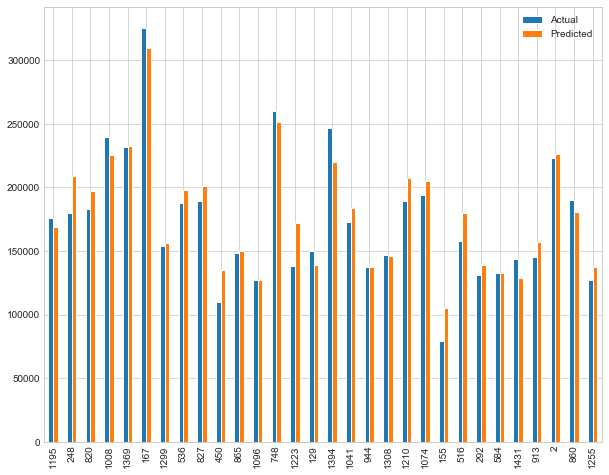

In [23]:
#Lasso model
lasso_pipeline = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1, tol = 0.1))
lasso_pipeline.fit(X_train, Y_train)
result(lasso_pipeline)

THe accuracy of training set si is  0.9030732322509623
THe accuracy of testing set si is  0.8838636543981571
      Actual      Predicted
1195  176000  168705.097321
248   180000  208944.798141
820   183000  197353.083109
1008  240000  225919.012111
1369  232000  232840.162838
167   325624  309495.826130
1299  154000  156111.723525
536   188000  198226.103368
827   189000  201011.288135
450   110000  135456.586529
865   148500  149699.842711
1096  127000  127252.998164
748   260400  251654.990014
1223  137900  172466.523584
129   150000  138734.070142
1394  246578  220207.737043
1041  173000  183609.302031
944   137500  138006.876617
1308  147000  145852.905609
1210  189000  207373.350409
1074  194000  205239.126490
155    79000  105414.596957
516   158000  180313.807251
292   131000  139418.843128
584   133000  132360.128150
1431  143750  128567.923018
913   145000  157385.511900
2     223500  225973.900709
860   189950  180941.606627
1255  127500  137950.919860
The root mean squared e

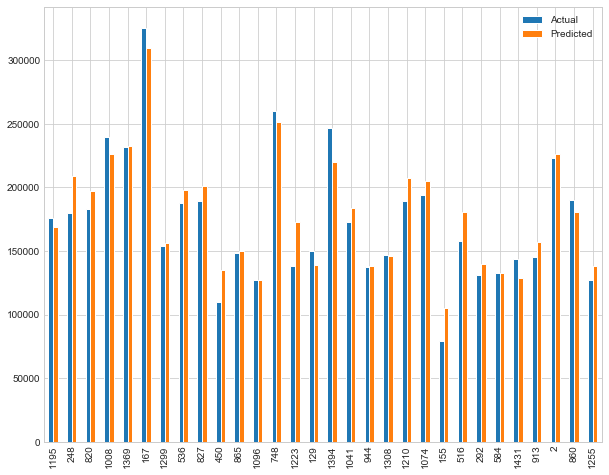

In [24]:
#ElasticNet model
ENet_pipeline = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3, tol = 0.1))
ENet_pipeline.fit(X_train, Y_train)
result(ENet_pipeline)

THe accuracy of training set si is  0.9151983631400771
THe accuracy of testing set si is  0.9068404049309187
      Actual      Predicted
1195  176000  164366.160156
248   180000  203713.214844
820   183000  196636.604492
1008  240000  224925.444336
1369  232000  227579.290527
167   325624  293597.867676
1299  154000  159320.915527
536   188000  196919.896484
827   189000  199441.973633
450   110000  129032.278320
865   148500  147586.664062
1096  127000  121108.581543
748   260400  251187.832520
1223  137900  180858.587891
129   150000  149347.453613
1394  246578  224176.330811
1041  173000  175219.118652
944   137500  160708.448242
1308  147000  143427.554688
1210  189000  199380.650879
1074  194000  200373.145020
155    79000   99473.102051
516   158000  180446.693848
292   131000  126687.094727
584   133000  122186.063477
1431  143750  131962.342041
913   145000  166211.478516
2     223500  225349.603516
860   189950  173620.203613
1255  127500  129870.642578
The root mean squared e

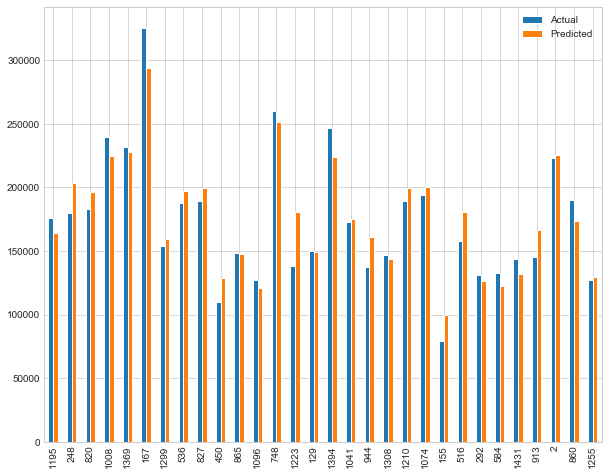

In [25]:
#Kernel Ridge model
KRR_pipeline = KernelRidge(alpha=0.05, kernel='polynomial', degree = 1, coef0 = 2)
KRR_pipeline.fit(X_train, Y_train)
result(KRR_pipeline)

THe accuracy of training set si is  0.9824846399818953
THe accuracy of testing set si is  0.8824772479467998
      Actual      Predicted
1195  176000  174473.341250
248   180000  185749.884583
820   183000  187547.123750
1008  240000  235950.222083
1369  232000  235917.577500
167   325624  316619.365833
1299  154000  150628.785417
536   188000  190130.694583
827   189000  188784.368333
450   110000  110219.829167
865   148500  144004.773750
1096  127000  121904.017500
748   260400  251312.380833
1223  137900  139014.356667
129   150000  147086.852917
1394  246578  230775.407917
1041  173000  175096.967083
944   137500  151834.630833
1308  147000  143058.391250
1210  189000  186444.763333
1074  194000  197671.222917
155    79000   85556.992917
516   158000  169885.094583
292   131000  131799.006667
584   133000  128377.882917
1431  143750  141148.840000
913   145000  147085.206250
2     223500  221837.355417
860   189950  184043.076667
1255  127500  127206.064167
The root mean squared e

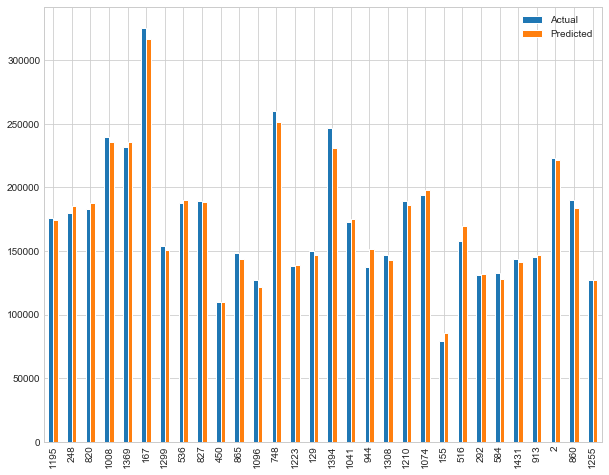

In [26]:
#RandomForestRegressor model
MAXDEPTH = 60
rf_model = RandomForestRegressor(n_estimators=2400,  
                             max_depth= MAXDEPTH,     
                             min_samples_split= 2,    
                             oob_score = True,        
                             n_jobs = -1,             
                             )
rf_model.fit(X_train,Y_train)
result(rf_model)

THe accuracy of training set si is  0.9900462134414724
THe accuracy of testing set si is  0.9307514323624226
      Actual      Predicted
1195  176000  171510.946971
248   180000  182340.893783
820   183000  184493.132572
1008  240000  239056.467625
1369  232000  232960.791298
167   325624  325481.999323
1299  154000  154478.788442
536   188000  188980.002635
827   189000  188300.355295
450   110000  109935.450958
865   148500  148324.045172
1096  127000  126700.748710
748   260400  260714.490251
1223  137900  137412.981160
129   150000  150357.239644
1394  246578  245659.634752
1041  173000  173465.312554
944   137500  138070.276207
1308  147000  146822.624090
1210  189000  190091.221776
1074  194000  193800.432292
155    79000   78942.352488
516   158000  158873.778083
292   131000  130716.674754
584   133000  134509.308094
1431  143750  142343.078358
913   145000  144822.618259
2     223500  222086.240685
860   189950  188527.155640
1255  127500  127521.587924
The root mean squared e

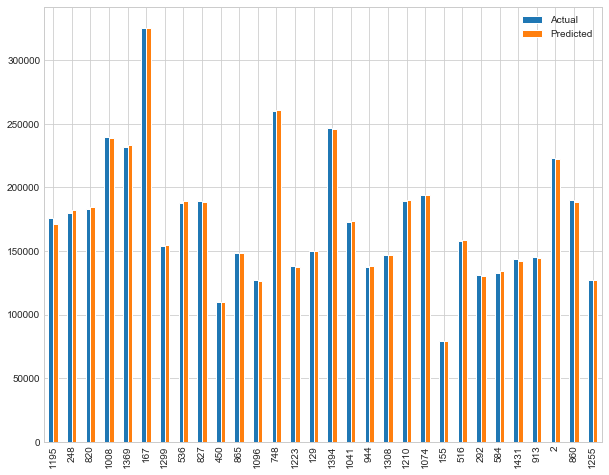

In [27]:
#Gradient Boosting model
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
Gboost_pipeline = make_pipeline(GBoost)
Gboost_pipeline.fit(X_train, Y_train)
result(Gboost_pipeline)

THe accuracy of training set si is  0.9714314282627309
THe accuracy of testing set si is  0.9308682880618266
      Actual      Predicted
1195  176000  161780.926019
248   180000  193082.210660
820   183000  199301.278045
1008  240000  222893.155208
1369  232000  233320.933437
167   325624  324994.784057
1299  154000  161685.194134
536   188000  190681.852936
827   189000  190715.065124
450   110000  110628.738150
865   148500  138498.695403
1096  127000  125911.904833
748   260400  257778.585723
1223  137900  136361.288840
129   150000  151579.181844
1394  246578  239841.496842
1041  173000  172405.151983
944   137500  150423.714639
1308  147000  147606.083699
1210  189000  196168.684113
1074  194000  198922.621221
155    79000   82748.233060
516   158000  164954.726330
292   131000  128571.679836
584   133000  133996.596557
1431  143750  134708.272653
913   145000  156850.131440
2     223500  220341.433515
860   189950  188748.376604
1255  127500  129950.891763
The root mean squared e

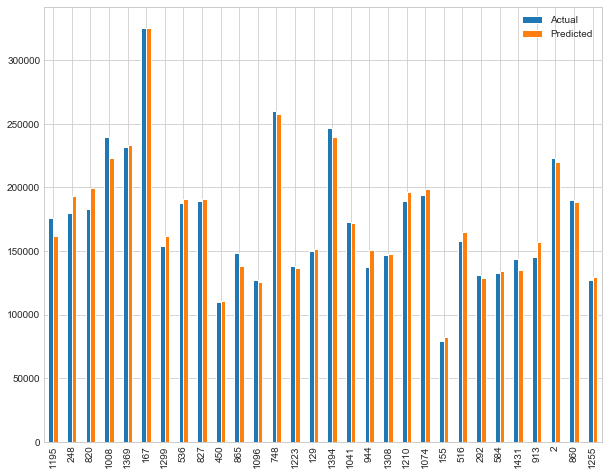

In [28]:
#LightGBM model
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
gbm_pipeline = make_pipeline(gbm)
gbm_pipeline.fit(X_train, Y_train)
result(gbm_pipeline)